<a href="https://colab.research.google.com/github/amadousysada/Sentiment-Analysis/blob/main/notebooks/p7_02_modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import des librairies

In [9]:
%%time
import time
init_time = time.time()

import os
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Installation du package gensim
!pip install --no-cache-dir -q gensim
import gensim
from gensim.models import Word2Vec

import numpy as np
import pandas as pd
import sklearn

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec


import seaborn as sns

# Tensorflow
import tensorflow as tf
import tensorflow_text as text

#Scikit-learn
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, mean_squared_error
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier

# Modèles de Boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# MLFLOW
!pip install mlflow -q
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

print("Python version:", sys.version)
print("Version info.:", sys.version_info)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("skearn version:", sklearn.__version__)
#print("nltk version:", nltk.__version__)
print("tensorflow version:", tf.__version__)
print("tensorflow_text version:", text.__version__)

Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Version info.: sys.version_info(major=3, minor=11, micro=12, releaselevel='final', serial=0)
pandas version: 2.2.2
numpy version: 1.26.4
skearn version: 1.6.1
tensorflow version: 2.18.0
tensorflow_text version: 2.18.1
CPU times: user 26.1 ms, sys: 2.45 ms, total: 28.6 ms
Wall time: 4.52 s


In [2]:
MLFLOW_TRACKING_URI = "https://mlflow.amadousy.dev"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# Chargement des données

In [3]:
path = "/content/drive/MyDrive/data/sentiments"
#path = "./data/sentiments"

In [4]:
for name in ["tweets_df_tfidf_1gram", "embeddings_bert", "embeddings_fasttext", "embeddings_word2vec"]:
    size = os.path.getsize(os.path.join(path, f"{name}.npy")) / 1e6
    print(f"{name}: {size:.2f} MB")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/data/sentiments/tweets_df_tfidf_1gram.npy'

In [5]:
%%time
tweets_df_tfidf_1gram = np.load(os.path.join(path, "tweets_df_tfidf_1gram.npy"), allow_pickle=True)

tweets_embeddings_bert = np.load(os.path.join(path, "embeddings_bert.npy"), allow_pickle=True)
tweets_embeddings_fasttext = np.load(os.path.join(path, "embeddings_fasttext.npy"), mmap_mode='r')
tweets_embeddings_word2vec = np.load(os.path.join(path, "embeddings_word2vec.npy"), mmap_mode='r')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/data/sentiments/tweets_df_tfidf_1gram.npy'

In [6]:
print(tweets_df_tfidf_1gram.item().shape)
print(tweets_embeddings_word2vec.shape)
print(tweets_embeddings_fasttext.shape)
print(tweets_embeddings_bert.shape)

NameError: name 'tweets_df_tfidf_1gram' is not defined

> Chargement de la variable cible

In [7]:
# Variable cible
Y = np.load(os.path.join(path, "targets.npy"), allow_pickle=True)
display(Y.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/data/sentiments/targets.npy'

In [ ]:
def plot_distribution(y_train, y_val, y_test):
  # Création des distributions
  dist_df = pd.DataFrame({
      "Train set": pd.Series(y_train).value_counts(normalize=True),
      "Validation set": pd.Series(y_val).value_counts(normalize=True),
      "Test set": pd.Series(y_test).value_counts(normalize=True)
  }).T

  # Optionnel : renommer les colonnes
  #dist_df.columns = ["Classe 1", "Classe 0"]

  # Barplot
  dist_df.plot(kind="bar", figsize=(8, 5), colormap="Set2")
  plt.title("Répartition des classes dans y_train, y_val et y_test")
  plt.ylabel("Proportion")
  plt.xticks(rotation=0)
  plt.ylim(0, 1)
  plt.legend(title="Classe")
  plt.tight_layout()
  plt.show()


def split_train_val_test(X, y, sample_size=None, test_size=0.2, val_size=0.2, random_state=42):
    """
    Splitte un jeu de données en trois sous-ensembles : train, validation et test.

    Paramètres :
    -----------
    X : array-like ou sparse matrix
        Matrice des features (peut être dense ou sparse).

    y : array-like
        Vecteur cible (labels ou classes).

    sample_size : int ou None (default=None)
        Si spécifié, un sous-échantillon (stratifié) de cette taille est prélevé depuis X/y avant le split.

    test_size : float (default=0.2)
        Proportion du test set par rapport à l'ensemble X (ou X échantillonné).

    val_size : float (default=0.2)
        Proportion du validation set par rapport à (train + val).

    random_state : int (default=42)
        Graine pour la reproductibilité.

    Retourne :
    ---------
    X_train, X_val, X_test, y_train, y_val, y_test : datasets splités avec stratification.
    """

    if sample_size is not None:
        X_sample, _, y_sample, _ = train_test_split(
            X, y, train_size=sample_size, stratify=y, random_state=random_state
        )
    else:
        X_sample, y_sample = X, y

    # Split temporaire : train_val vs test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_sample, y_sample, test_size=test_size, stratify=y_sample, random_state=random_state
    )

    # Split train vs validation (sur le train_val)
    val_split = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_split, stratify=y_train_val, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test


# Approche 1: Modéle sur mesure

- Logistic Regression
- Ridge Classifier
- Naive Bayes
- Light Gradient Boosting Machine
- Gradient Boosting Classifier
- linear discriminant analysis

In [ ]:
import re
import unicodedata

def slugify(text):
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(r'[^a-z0-9]+', '-', text)
    text = text.strip('-')
    return text

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Ridge Classifier": RidgeClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', n_jobs=-1),
    "LightGBM": LGBMClassifier(verbose=-1, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100),
}

In [ ]:
from tqdm import tqdm
tqdm.pandas()

def evaluate_models(x_train, x_valid, y_train, y_valid, cv=3, scoring="accuracy", source=""):
    results = []
    signature = infer_signature(x_train, y_train)
    for name, model in tqdm(models.items()):
      start_time = time.time()
      print(f"Evaluating {name}...")
      mlflow.set_experiment(f"{source}-{slugify(name)}")
      with mlflow.start_run():
        scores = cross_val_score(model, x_train, y_train, cv=cv, scoring=scoring)
        y_pred = model.fit(x_train, y_train).predict(x_valid)
        cv_score = scores.mean()
        val_score = model.score(x_valid, y_valid)
        precision = precision_score(y_valid, y_pred)
        recall = recall_score(y_valid, y_pred)
        f1 = f1_score(y_valid, y_pred)
        auc = roc_auc_score(y_valid, y_pred)
        mse = mean_squared_error(y_valid, y_pred)
        train_time = time.time() - start_time

        results.append({
            "Model": name,
            "cv_score": cv_score,
            "val_score": val_score,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "auc": auc,
            "mse": mse,
            "train_time (s)": train_time
        })
        mlflow.log_params(model.get_params())
        mlflow.log_metric("cv_score", cv_score)
        mlflow.log_metric("val_score", val_score)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("auc", auc)
        mlflow.log_metric("loss", mse)
        mlflow.log_metric("train_time", train_time)
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model-artifact",
            signature=signature,
            input_example=x_train[:10],
            registered_model_name=slugify(name)
        )

    print("\n")

    return pd.DataFrame(results).sort_values(by="val_score", ascending=False)

def show_calibration_curve(models, X_valid, y_valid, exclude=None):
  if exclude is None:
    exclude = []
  fig = plt.figure(figsize=(16, 10))
  gs = GridSpec(7, 3)
  colors = plt.get_cmap("Dark2")

  ax_calibration_curve = fig.add_subplot(gs[:2, :2])
  calibration_displays = {}
  markers = ["^", "v", "s", "o", "2"]
  for i, (name, clf) in enumerate(models.items()):
    if name not in exclude:
      display = CalibrationDisplay.from_estimator(
          clf,
          X_valid,
          y_valid,
          n_bins=10,
          name=name,
          ax=ax_calibration_curve,
          color=colors(i),
          marker=markers[i],
      )
      calibration_displays[name] = display

  ax_calibration_curve.grid()
  ax_calibration_curve.set_title("Calibration plots")

skf = StratifiedKFold(n_splits=4)

## | Tf-idf

In [ ]:
X_train_tfidf, X_valid_tfidf, X_test_tfidf, y_train_tfidf, y_valid_tfidf, y_test_tfidf = split_train_val_test(tweets_df_tfidf_1gram.item(), Y, sample_size=20000)
print("Répartition dans y_train    :", pd.Series(y_train_tfidf).value_counts(normalize=True))
print("Répartition dans y_validation:", pd.Series(y_valid_tfidf).value_counts(normalize=True))
print("Répartition dans y_test :", pd.Series(y_test_tfidf).value_counts(normalize=True))
plot_distribution(y_train_tfidf, y_valid_tfidf, y_test_tfidf)

In [ ]:
skf.get_n_splits(X_train_tfidf, y_train_tfidf)
for i, (train_index, test_index) in enumerate(skf.split(X_train_tfidf, y_train_tfidf)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

In [ ]:
%%time
tfidf_results_df = evaluate_models(X_train_tfidf, X_valid_tfidf, y_train_tfidf, y_valid_tfidf, cv=skf, source="tfidf")

In [16]:
tfidf_results_df

NameError: name 'tfidf_results_df' is not defined

## | Word2Vec

Répartition dans y_train    : 1    0.500083
0    0.499917
Name: proportion, dtype: float64
Répartition dans y_validation: 0    0.5
1    0.5
Name: proportion, dtype: float64
Répartition dans y_test : 1    0.5
0    0.5
Name: proportion, dtype: float64


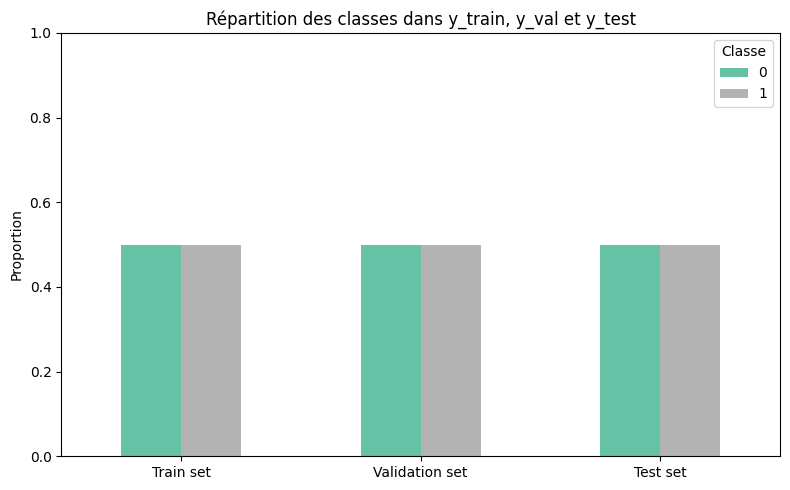

CPU times: user 1.61 s, sys: 2.13 s, total: 3.73 s
Wall time: 32.5 s


In [30]:
%%time
X_train_w2v, X_valid_w2v, X_test_w2v, y_train_w2v, y_valid_w2v, y_test_w2v = split_train_val_test(tweets_embeddings_word2vec, Y, sample_size=20000)
print("Répartition dans y_train    :", pd.Series(y_train_w2v).value_counts(normalize=True))
print("Répartition dans y_validation:", pd.Series(y_valid_w2v).value_counts(normalize=True))
print("Répartition dans y_test :", pd.Series(y_test_w2v).value_counts(normalize=True))
plot_distribution(y_train_w2v, y_valid_w2v,  y_test_w2v)

In [ ]:
%%time
w2v_results__df = evaluate_models(X_train_w2v, X_valid_w2v, y_train_w2v, y_valid_w2v, cv=skf)

  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Logistic Regression...


 20%|██        | 1/5 [00:18<01:14, 18.60s/it]

Evaluating Ridge Classifier...


 40%|████      | 2/5 [00:19<00:24,  8.21s/it]

Evaluating XGBoost...


 60%|██████    | 3/5 [01:43<01:25, 42.62s/it]

Evaluating LightGBM...


 80%|████████  | 4/5 [02:23<00:41, 41.77s/it]

Evaluating Random Forest...


100%|██████████| 5/5 [04:29<00:00, 53.87s/it]



CPU times: user 6min 12s, sys: 1.6 s, total: 6min 14s
Wall time: 4min 29s


In [ ]:
w2v_results__df

,Model,cv_score,val_score,precision,recall,f1,auc,mse,train_time (s)
0,Logistic Regression,0.720917,0.72775,0.721655,0.7415,0.731443,0.72775,0.27225,18.597020
1,Ridge Classifier,0.716833,0.72250,0.717285,0.7345,0.725791,0.72250,0.27750,0.935626
3,LightGBM,0.711083,0.69725,0.699142,0.6925,0.695805,0.69725,0.30275,40.463776
2,XGBoost,0.697333,0.69375,0.698616,0.6815,0.689952,0.69375,0.30625,83.560140
4,Random Forest,0.697250,0.68850,0.703344,0.6520,0.676700,0.68850,0.31150,125.763565


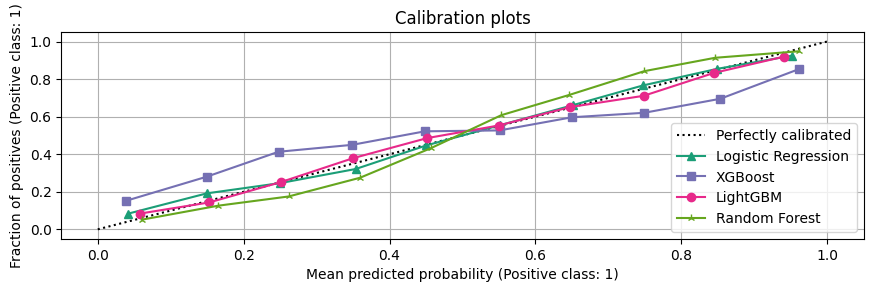

In [ ]:
show_calibration_curve(models, X_test_w2v, y_test_w2v, exclude=["Ridge Classifier"])

## | FastText

In [ ]:
%%time
X_train_ft, X_valid_ft, X_test_ft, y_train_ft, y_valid_ft, y_test_ft = split_train_val_test(tweets_embeddings_fasttext, Y, sample_size=20000)

CPU times: user 20.6 s, sys: 17.5 s, total: 38.1 s
Wall time: 2min 52s


In [ ]:
%%time
ft_results_df = evaluate_models(X_train_ft, X_valid_ft, y_train_ft, y_valid_ft, cv=skf)

  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating Logistic Regression...


 20%|██        | 1/5 [00:36<02:25, 36.27s/it]

Evaluating Ridge Classifier...


 40%|████      | 2/5 [00:37<00:46, 15.51s/it]

Evaluating XGBoost...


 60%|██████    | 3/5 [02:03<01:35, 47.86s/it]

Evaluating LightGBM...


 80%|████████  | 4/5 [02:45<00:45, 45.40s/it]

Evaluating Random Forest...


100%|██████████| 5/5 [04:50<00:00, 58.19s/it]



CPU times: user 6min 51s, sys: 1.74 s, total: 6min 53s
Wall time: 4min 50s


In [ ]:
display(ft_results_df)

,Model,cv_score,val_score,precision,recall,f1,auc,mse,train_time (s)
0,Logistic Regression,0.719167,0.72125,0.720259,0.7235,0.721876,0.72125,0.27875,36.267372
1,Ridge Classifier,0.714500,0.72100,0.721000,0.7210,0.721000,0.72100,0.27900,0.972697
2,XGBoost,0.696167,0.69600,0.695414,0.6975,0.696455,0.69600,0.30400,86.341797
3,LightGBM,0.701167,0.69525,0.697521,0.6895,0.693488,0.69525,0.30475,41.629077
4,Random Forest,0.689417,0.68475,0.700054,0.6465,0.672212,0.68475,0.31525,125.697958


## Comparaison des modèles

In [ ]:
tfidf_results_df['Corpus'] = 'tfidf'
w2v_results__df['Corpus'] = 'word2vec'
ft_results_df['Corpus'] = 'fasttext'

In [ ]:
res_all_df = pd.concat([tfidf_results_df, w2v_results__df, ft_results_df])
res_all_df.rename(columns={
    "val_score": "Accuracy",
    "f1": "F1-score",
    "auc": "AUC",
    "train_time (s)": "Train Time (s)"
}, inplace=True)

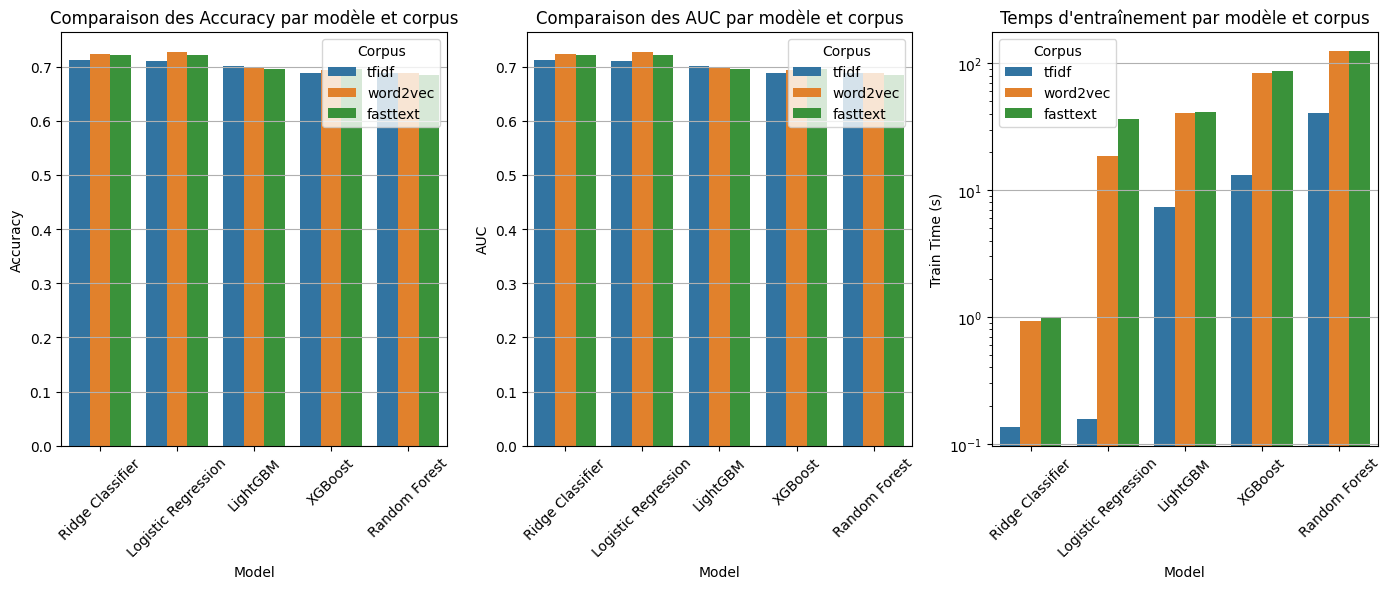

In [ ]:
fig = plt.figure(figsize=(14, 6))

# F1-score
ax = fig.add_subplot(131)
sns.barplot(data=res_all_df, x="Model", y="Accuracy", hue="Corpus")
plt.title("Comparaison des Accuracy par modèle et corpus")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()

# AUC
ax = fig.add_subplot(132)
sns.barplot(data=res_all_df, x="Model", y="AUC", hue="Corpus")
plt.title("Comparaison des AUC par modèle et corpus")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()

# Train Time
ax = fig.add_subplot(133)
sns.barplot(data=res_all_df, x="Model", y="Train Time (s)", hue="Corpus")
plt.title("Temps d'entraînement par modèle et corpus")
plt.xticks(rotation=45)
plt.yscale("log")
plt.grid(axis="y")
plt.tight_layout()

plt.show()

In [ ]:
del tfidf_results_df
del w2v_results__df
del ft_results_df
del X_test_tfidf
del X_valid_tfidf
del X_train_tfidf
del y_valid_tfidf
del y_train_tfidf
del y_test_tfidf

**Conclusion**: Parmi l’ensemble des modèles testés sur les trois représentations textuelles, **Logistic Regression avec Word2Vec** obtient les meilleurs résultats en termes de F1-score et d’AUC.
Il offre un excellent compromis entre performance et robustesse, tout en restant simple à entraîner.
Nous le retenons donc comme **modèle de référence pour cette prémiére approche**.


## Optimisation du modéle 1: Logistic Regression + Word2vec

In [ ]:
!pip install optuna
import optuna

In [ ]:
def objective(trial):
    # Hyperparamètres à optimiser
    C = trial.suggest_loguniform('C', 1e-2, 1e2)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', None])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'saga'])

    # Only needed if penalty is elasticnet
    l1_ratio = None
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0.0, 0.5)

    # Skip invalid combinations manually
    invalid_combo = (
        (penalty == 'l1' and solver not in ['liblinear', 'saga']) or
        (penalty == 'elasticnet' and solver != 'saga') or
        (penalty == 'none' and solver == 'liblinear')
    )
    # Skip invalid combinations manually
    invalid_combo = (
        (penalty == 'l1' and solver not in ['liblinear', 'saga']) or
        (penalty == 'elasticnet' and solver != 'saga') or
        (penalty == None and solver == 'liblinear')
    )

    if invalid_combo:
        return 0.0

    # Modèle
    model = LogisticRegression(
        C=C,
        penalty=penalty,
        class_weight=class_weight,
        max_iter=1000,
        solver=solver,
        l1_ratio=l1_ratio,
        random_state=42
    )

    # Cross-validation
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_w2v, y_train_w2v, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    return score

In [ ]:
%%time
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25, n_jobs=-1)

[I 2025-05-17 21:25:23,391] A new study created in memory with name: no-name-3838aabc-a169-43f0-a134-b03971fa3891
[I 2025-05-17 21:25:41,876] Trial 1 finished with value: 0.7183333333333334 and parameters: {'C': 0.4001041960316794, 'penalty': 'l2', 'class_weight': None, 'solver': 'liblinear'}. Best is trial 1 with value: 0.7183333333333334.
[I 2025-05-17 21:25:44,983] Trial 0 finished with value: 0.71925 and parameters: {'C': 0.025699829117043216, 'penalty': 'l2', 'class_weight': 'balanced', 'solver': 'saga'}. Best is trial 0 with value: 0.71925.
[I 2025-05-17 21:25:46,359] Trial 2 finished with value: 0.7193333333333334 and parameters: {'C': 0.09347389563665467, 'penalty': 'l1', 'class_weight': None, 'solver': 'liblinear'}. Best is trial 2 with value: 0.7193333333333334.
[I 2025-05-17 21:28:07,281] Trial 3 finished with value: 0.7181666666666666 and parameters: {'C': 0.6280046603347998, 'penalty': 'elasticnet', 'class_weight': 'balanced', 'solver': 'saga', 'l1_ratio': 0.32859527488318

CPU times: user 1min 30s, sys: 3.11 s, total: 1min 33s
Wall time: 11min 47s


In [ ]:
print("Best score (F1):", study.best_value)
print("Best params:", study.best_params)

Best score (F1): 0.7200833333333333
Best params: {'C': 0.017986470213517514, 'penalty': 'l2', 'class_weight': 'balanced', 'solver': 'liblinear'}


In [ ]:
# La relation entre chaque hyperparamètre et la valeur de la fonction objectif.
optuna.visualization.plot_slice(study)

In [ ]:
mlflow.set_experiment("logistic-regression-with-bert-optimised-hyperparameters")
with mlflow.start_run():
  from sklearn.metrics import classification_report

  lr_model = LogisticRegression(**study.best_params, max_iter=1000)
  lr_model.fit(X_train_w2v, y_train_w2v)

  # prédiction
  y_pred = lr_model.predict(X_valid_w2v)
  accuracy = accuracy_score(y_valid_w2v, y_pred)
  loss = mean_squared_error(y_valid_w2v, y_pred)

  mlflow.log_params(study.best_params)
  mlflow.log_metric("accuracy", accuracy)
  mlflow.log_metric("loss (mse)", loss)

  # évaluation
  print("Accuracy:", accuracy)
  print("MSE:", loss)
  print(classification_report(y_valid_w2v, y_pred))

Accuracy: 0.72075
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      2000
           1       0.72      0.72      0.72      2000

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000



> Validation avec Test set

In [ ]:
y_pred = lr_model.predict(X_test_w2v)
print("Accuracy:", accuracy_score(y_test_w2v, y_pred))
print(classification_report(y_test_w2v, y_pred))

Accuracy: 0.7285
              precision    recall  f1-score   support

           0       0.73      0.72      0.73      2000
           1       0.73      0.73      0.73      2000

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000



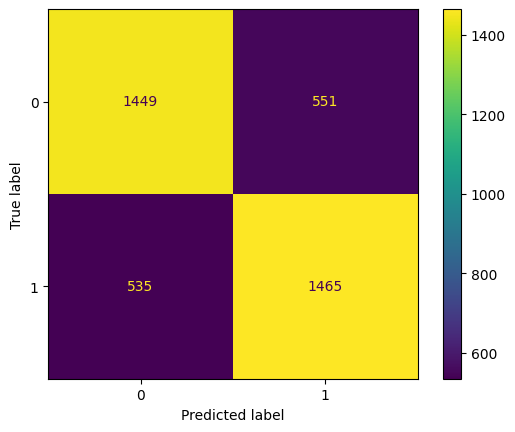

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(lr_model, X_test_w2v, y_test_w2v)
plt.show()

> Sauvegarde du modéle 1

In [ ]:
%%time
import pickle
pickle.dump(lr_model, open(os.path.join(path, "lr_model.pkl"), "wb"))
del lr_model

# Approche 2: Modèle sur mesure avancé (Reseau de Neurone)

In [ ]:
tokenized_tweets = pd.read_csv(os.path.join(path, "tokenized_tweets.csv"))

In [ ]:
tokenized_tweets.head()

,tokenized_tweets
0,"['switchfoot', 'awww', 'bummer', 'shoulda', 'g..."
1,"['upset', 'update', 'facebook', 'texting', 'mi..."
2,"['kenichan', 'dived', 'many', 'time', 'ball', ..."
3,"['whole', 'body', 'feel', 'itchy', 'like', 'fi..."
4,"['nationwideclass', 'behave', 'mad', 'see']"


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input

def build_model(weights=None, input_shape=(16, 300), dropout_rate=0.5, dense_units=32, lstm_units=32):
  model = Sequential()

  model.add(Input(shape=input_shape))
  model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
  model.add(Dropout(dropout_rate))
  model.add(Dense(dense_units, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))  # pour classification binaire

  return model

def sentence_to_sequence(tokens, model_embedding, max_len=30, dim=300):
    vectors = [model_embedding.wv[word] if word in model_embedding.wv else np.zeros(dim) for word in tokens]
    # Padding or trimming
    vectors = vectors[:max_len] + [np.zeros(dim)] * (max_len - len(vectors))
    return np.array(vectors)

res = []

## | Word2Vec



> Chargement du modéle pretrainé de Word2vec



In [ ]:
%%time
w2v_model = Word2Vec.load(os.path.join(path, "word2vec_model.model"))

CPU times: user 6.49 s, sys: 2.09 s, total: 8.59 s
Wall time: 36.2 s


In [ ]:
%%time
train_token, val_token, test_token, y_train_w2v, y_valid_w2v, y_test_w2v = split_train_val_test(tokenized_tweets.tokenized_tweets, Y, sample_size=20000)

CPU times: user 906 ms, sys: 89.9 ms, total: 996 ms
Wall time: 1.02 s


In [ ]:
max_len = max(map(len, tokenized_tweets))
print(f"Le tweet le plus long contient {max_len} tokens")

Le tweet le plus long contient 16 tokens




> Extracion des sequences



In [ ]:
%%time
train_w2v_set =  np.array([sentence_to_sequence(sentence, w2v_model, max_len=max_len) for sentence in train_token])
val_w2v_set =  np.array([sentence_to_sequence(sentence, w2v_model, max_len=max_len) for sentence in val_token])
test_w2v_set =  np.array([sentence_to_sequence(sentence, w2v_model, max_len=max_len) for sentence in test_token])

CPU times: user 2.45 s, sys: 1.11 s, total: 3.57 s
Wall time: 3.6 s


In [ ]:
train_w2v_set.shape

(12000, 16, 300)

In [ ]:
%%time
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'auc', 'precision', 'recall'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 64)             │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,361 (341.25 KB)

 Trainable params: 87,361 (341.25 KB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 91 ms, sys: 918 µs, total: 91.9 ms
Wall time: 90.3 ms


In [ ]:
%%time

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

fit_time = time.time()
history = model.fit(
    x=train_w2v_set,
    y=y_train_w2v,
    epochs=30,
    batch_size=32,
    validation_data=(val_w2v_set, y_valid_w2v),
    callbacks=callbacks,

)
fit_time = time.time() - fit_time

res.append({
    "Embeddings": "word2vec",
    "val_score": np.mean(history.history['val_accuracy']),
    "val_loss": np.mean(history.history['val_loss']),
    "auc": np.mean(history.history['val_auc']),
    "precision": np.mean(history.history['val_precision']),
    "recall": np.mean(history.history['val_recall']),
    "train_time (s)": fit_time
})

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.5100 - auc: 0.5141 - loss: 0.6952 - mse: 0.2510 - precision: 0.5083 - recall: 0.5503 - val_accuracy: 0.5165 - val_auc: 0.5582 - val_loss: 0.6910 - val_mse: 0.2489 - val_precision: 0.5091 - val_recall: 0.9190
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.5204 - auc: 0.5331 - loss: 0.6917 - mse: 0.2493 - precision: 0.5135 - recall: 0.5544 - val_accuracy: 0.5518 - val_auc: 0.5753 - val_loss: 0.6870 - val_mse: 0.2469 - val_precision: 0.5482 - val_recall: 0.5885
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.5458 - auc: 0.5670 - loss: 0.6866 - mse: 0.2467 - precision: 0.5426 - recall: 0.5465 - val_accuracy: 0.5515 - val_auc: 0.5772 - val_loss: 0.6851 - val_mse: 0.2460 - val_precision: 0.5648 - val_recall: 0.4490
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.5539 - auc: 0.5792 - loss: 0.6825 - mse: 0.2448 - precision: 0.5466 - recall: 0.6079 - val_accuracy: 0.5663

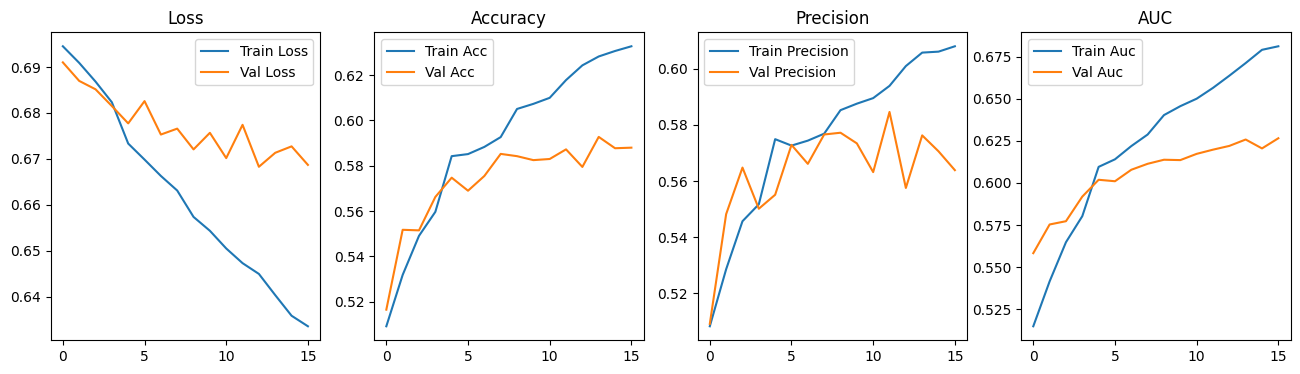

In [ ]:
fig = plt.figure(figsize=(16, 4))

fig.add_subplot(1, 4, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

fig.add_subplot(1, 4, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

fig.add_subplot(1, 4, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.title('Precision')
plt.legend()

fig.add_subplot(1, 4, 4)
plt.plot(history.history['auc'], label='Train Auc')
plt.plot(history.history['val_auc'], label='Val Auc')
plt.title('AUC')
plt.legend()

plt.show()

## | FastText

In [ ]:
from gensim.models import FastText

In [ ]:
%%time
ft_model = FastText.load(os.path.join(path, "fasttext_model.model"))

CPU times: user 41.7 s, sys: 2.35 s, total: 44.1 s
Wall time: 45.7 s


In [ ]:
%%time
train_token, val_token, test_token, y_train_ft, y_valid_ft, y_test_ft = split_train_val_test(tokenized_tweets.tokenized_tweets, Y, sample_size=20000)

CPU times: user 773 ms, sys: 38.1 ms, total: 811 ms
Wall time: 806 ms




> Extracion des sequences



In [ ]:
%%time
max_len = max(map(len, tokenized_tweets))
print(f"Le tweet le plus long contient {max_len} tokens")
train_ft_set =  np.array([sentence_to_sequence(sentence, ft_model, max_len=max_len) for sentence in train_token])
val_ft_set =  np.array([sentence_to_sequence(sentence, ft_model, max_len=max_len) for sentence in val_token])
test_ft_set =  np.array([sentence_to_sequence(sentence, ft_model, max_len=max_len) for sentence in test_token])

Le tweet le plus long contient 16 tokens
CPU times: user 4.81 s, sys: 236 ms, total: 5.05 s
Wall time: 5.03 s


In [ ]:
train_ft_set.shape

(12000, 16, 300)

In [ ]:
%%time
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'auc', 'precision', 'recall'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        85,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,361 (341.25 KB)

 Trainable params: 87,361 (341.25 KB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 119 ms, sys: 4.83 ms, total: 124 ms
Wall time: 144 ms


In [ ]:
%%time

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

fit_time = time.time()
history = model.fit(
    x=train_ft_set,
    y=y_train_ft,
    epochs=30,
    batch_size=32,
    validation_data=(val_ft_set, y_valid_ft),
    callbacks=callbacks,

)
fit_time = time.time() - fit_time

res.append({
    "Embeddings": "fasttext",
    "val_score": np.mean(history.history['val_accuracy']),
    "val_loss": np.mean(history.history['val_loss']),
    "auc": np.mean(history.history['val_auc']),
    "precision": np.mean(history.history['val_precision']),
    "recall": np.mean(history.history['val_recall']),
    "train_time (s)": fit_time
})

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.5017 - auc: 0.4979 - loss: 0.6985 - precision: 0.5087 - recall: 0.5821 - val_accuracy: 0.5460 - val_auc: 0.5548 - val_loss: 0.6903 - val_precision: 0.5501 - val_recall: 0.5055
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5280 - auc: 0.5447 - loss: 0.6900 - precision: 0.5311 - recall: 0.5595 - val_accuracy: 0.5508 - val_auc: 0.5735 - val_loss: 0.6873 - val_precision: 0.5608 - val_recall: 0.4680
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.5448 - auc: 0.5627 - loss: 0.6873 - precision: 0.5483 - recall: 0.5756 - val_accuracy: 0.5533 - val_auc: 0.5768 - val_loss: 0.6851 - val_precision: 0.5471 - val_recall: 0.6180
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5583 - auc: 0.5821 - loss: 0.6830 - precision: 0.5552 - recall: 0.5905 - val_accuracy: 0.5602 - val_auc: 0.5881 - val_loss: 0.6831 - val_precision: 0.5461 - val_recall: 0.7140
Epoch 5/30
375/375 ━━━━━━━━

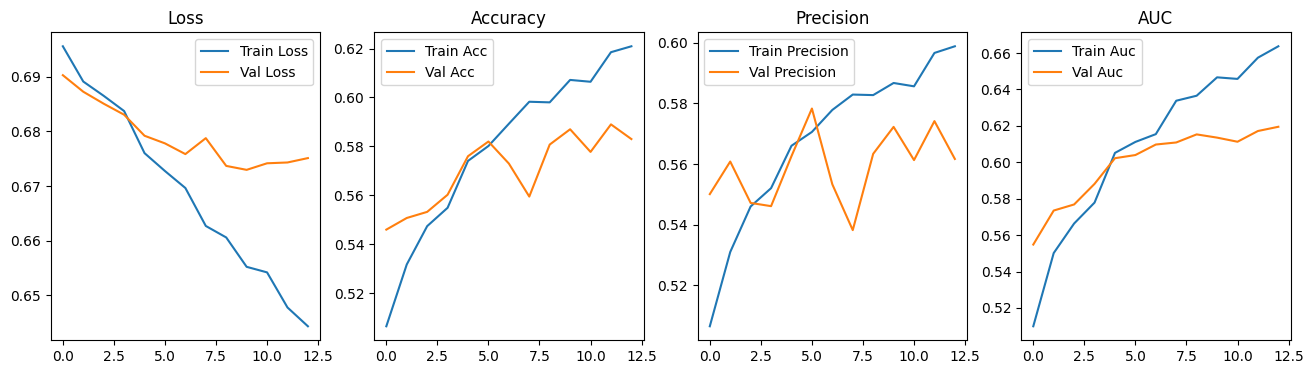

In [ ]:
fig = plt.figure(figsize=(16, 4))

fig.add_subplot(1, 4, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

fig.add_subplot(1, 4, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

fig.add_subplot(1, 4, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.title('Precision')
plt.legend()

fig.add_subplot(1, 4, 4)
plt.plot(history.history['auc'], label='Train Auc')
plt.plot(history.history['val_auc'], label='Val Auc')
plt.title('AUC')
plt.legend()

plt.show()

## Comparaison des embeddings (word2vec vs fasttext)

In [ ]:
res_all_df_2 = pd.DataFrame(res)
res_all_df_2

,Embeddings,val_score,auc,precision,recall,train_time (s),val_loss
0,word2vec,0.573469,0.605253,0.56309,0.677688,151.528498,NaN
1,fasttext,0.570635,0.599764,0.55917,0.673462,123.689417,0.67904


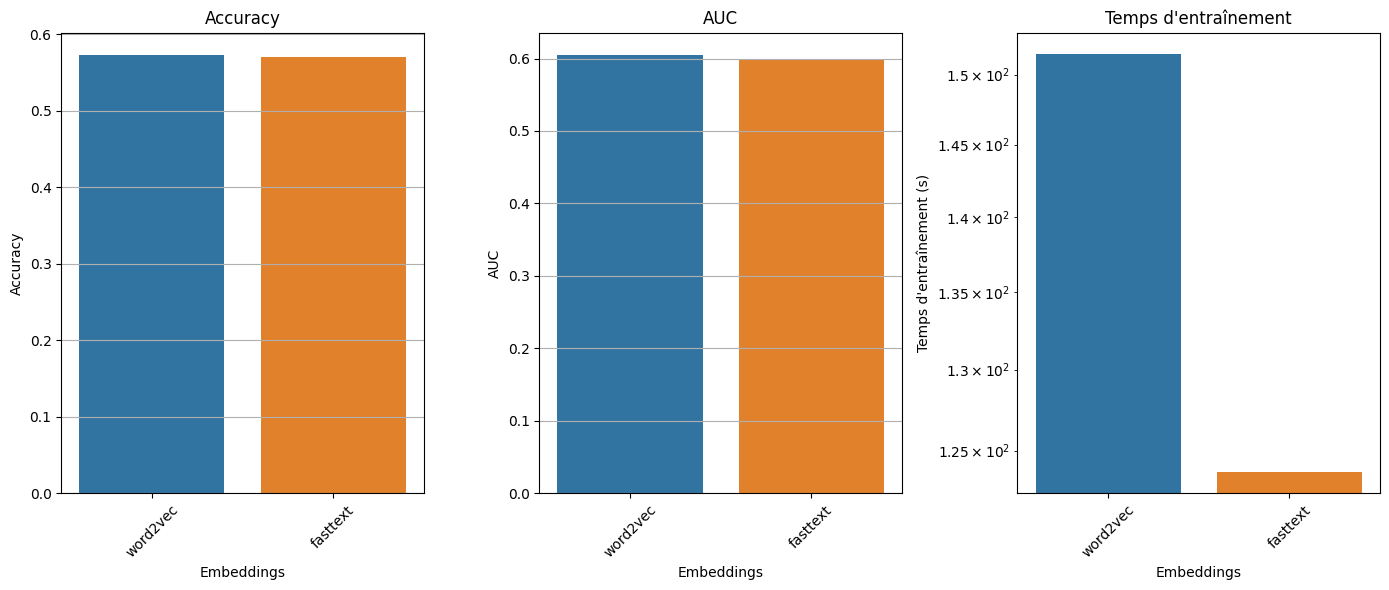

In [ ]:
fig = plt.figure(figsize=(14, 6))

# Accuracy
ax = fig.add_subplot(131)
sns.barplot(data=res_all_df_2, x="Embeddings", y="val_score", hue="Embeddings", ax=ax)
ax.set_title("Accuracy")
ax.set_ylabel("Accuracy")
plt.setp(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y")

# AUC
ax = fig.add_subplot(132)
sns.barplot(data=res_all_df_2, x="Embeddings", y="auc", hue="Embeddings", ax=ax)
ax.set_title("AUC")
ax.set_ylabel("AUC")
plt.setp(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y")

# Train Time
ax = fig.add_subplot(133)
sns.barplot(data=res_all_df_2, x="Embeddings", y="train_time (s)", hue="Embeddings", ax=ax)
ax.set_title("Temps d'entraînement")
ax.set_ylabel("Temps d'entraînement (s)")
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_yscale("log")
ax.grid(axis="y")

fig.tight_layout()
plt.show()

Les graphiques plus haut, nous montre:

- **Word2Vec** :
Surentraînement clair : la courbe de validation stagne voire descend légèrement sur certaines métriques alors que celle d'entraînement continue de progresser.

Plus de variance dans la précision et AUC côté validation.

- **FastText** :
Moins de surentraînement.

Plus stable sur la plupart des métriques.

Les courbes train/val sont plus proches, ce qui suggère une meilleure généralisation.

**Conclusion**
FastText semble légèrement meilleur pour la généralisation, même si Word2Vec donne de meilleures performances brutes sur le training.

## Optimisation des hyperparametes

In [ ]:
!pip install optuna optuna-integration -q
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow import keras

In [ ]:
def objective(trial):
    # Hyperparams à tuner
    lstm_units = trial.suggest_categorical("lstm_units", [32, 64, 128])
    dense_units = trial.suggest_int("dense_units", 16, 128, step=16)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    model = build_model(
        dropout_rate=dropout_rate,
        dense_units=dense_units,
        lstm_units=lstm_units
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    # Callback de pruning
    pruning_callback = TFKerasPruningCallback(trial, "val_accuracy")

    history = model.fit(
        train_ft_set, y_train_ft,
        validation_data=(val_ft_set, y_valid_ft),
        epochs=30,
        batch_size=batch_size,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
            pruning_callback
        ],
        verbose=0
    )

    return max(history.history["val_accuracy"])

In [ ]:
try:
  optuna.delete_study(study_name="lstm_hyperparameter_optimization", storage="sqlite:///study.db")
except:
  pass

In [ ]:
%%time
storage_url = "sqlite:///study.db"
study_name = "lstm_hyperparameter_optimization"
study = optuna.create_study(study_name=study_name, storage=storage_url, direction="maximize", load_if_exists=True)
study.optimize(objective, n_trials=50)

[I 2025-05-23 05:56:54,978] A new study created in RDB with name: lstm_hyperparameter_optimization
[I 2025-05-23 05:57:24,269] Trial 0 finished with value: 0.5842499732971191 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout_rate': 0.1261131693198527, 'learning_rate': 0.00017673822306257556, 'batch_size': 32}. Best is trial 0 with value: 0.5842499732971191.
[I 2025-05-23 05:57:32,707] Trial 1 finished with value: 0.5827500224113464 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout_rate': 0.25586660424609986, 'learning_rate': 0.003138920289914786, 'batch_size': 128}. Best is trial 0 with value: 0.5842499732971191.
[I 2025-05-23 05:57:49,980] Trial 2 finished with value: 0.6012499928474426 and parameters: {'lstm_units': 128, 'dense_units': 128, 'dropout_rate': 0.13986872037342196, 'learning_rate': 0.0011870248978417416, 'batch_size': 64}. Best is trial 2 with value: 0.6012499928474426.
[I 2025-05-23 05:58:18,934] Trial 3 finished with value: 0.5759999752044678 

CPU times: user 7min 12s, sys: 49.9 s, total: 8min 2s
Wall time: 6min 35s


In [ ]:
print("Best hyperparameters:")
print(study.best_params)

print("Best validation accuracy:", study.best_value)

Best hyperparameters:
{'lstm_units': 128, 'dense_units': 128, 'dropout_rate': 0.13986872037342196, 'learning_rate': 0.0011870248978417416, 'batch_size': 64}
Best validation accuracy: 0.6012499928474426




> Entrainer le modél final



In [ ]:
%%time
final_model = build_model(
  dropout_rate=study.best_params["dropout_rate"],
  dense_units=study.best_params["dense_units"],
  lstm_units=study.best_params["lstm_units"]
)

final_model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=study.best_params['learning_rate']),
  loss="binary_crossentropy",
  metrics=["accuracy"]
)

CPU times: user 85.6 ms, sys: 15.3 ms, total: 101 ms
Wall time: 98.9 ms


In [ ]:
%%time
history = final_model.fit(
    train_ft_set, y_train_ft,
    validation_data=(val_ft_set, y_valid_ft),
    epochs=30,
    batch_size=study.best_params["batch_size"],
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    ]
)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5026 - loss: 0.7003 - val_accuracy: 0.5410 - val_loss: 0.6875
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5514 - loss: 0.6846 - val_accuracy: 0.5573 - val_loss: 0.6844
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5826 - loss: 0.6726 - val_accuracy: 0.5652 - val_loss: 0.6800
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5918 - loss: 0.6625 - val_accuracy: 0.5775 - val_loss: 0.6773
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6243 - loss: 0.6499 - val_accuracy: 0.5765 - val_loss: 0.6786
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6398 - loss: 0.6332 - val_accuracy: 0.5845 - val_loss: 0.6781
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6477 - loss: 0.6187 - val_accuracy: 0.5810 - val_loss: 0.6845
CPU times: user 16 s, sys: 1.66 s, total: 17.6 s
Wall time: 13.3 s


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
y_preds_prob = final_model.predict(test_ft_set)
y_preds = np.where(y_preds_prob > 0.5, 1, 0)
print(classification_report(y_test_ft, y_preds))

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.59      0.49      0.54      2000
           1       0.56      0.66      0.61      2000

    accuracy                           0.57      4000
   macro avg       0.58      0.57      0.57      4000
weighted avg       0.58      0.57      0.57      4000



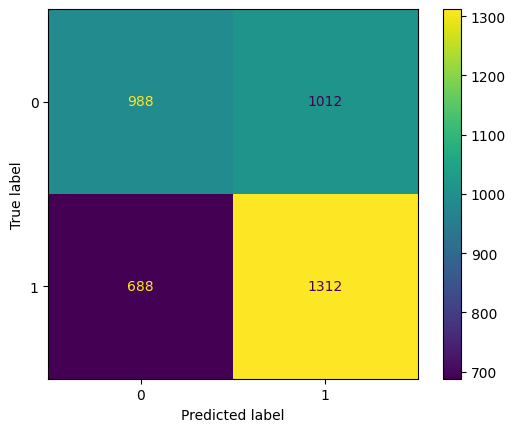

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_pred=y_preds, y_true=y_test_ft)
plt.show()

In [ ]:
final_model.save(os.path.join(path, "final_model.keras"))

# BERT - COMPLEMENT

In [ ]:
%%time
embeddings_bert = np.load(os.path.join(path, "embeddings_bert.npy"))
labels = np.load(os.path.join(path, "bert_labels.npy"))

CPU times: user 6.31 ms, sys: 10.7 ms, total: 17 ms
Wall time: 565 ms


In [ ]:
print(embeddings_bert.shape)
print(labels.shape)

(10000, 768)
(10000,)




> Split sets



In [ ]:
x_train, x_valid, x_test, y_train, y_valid, y_test = split_train_val_test(embeddings_bert, labels)

In [ ]:
print("Train Set :", x_train.shape)
print("Validation Set :", x_valid.shape)
print("Test Set :", x_test.shape)

Train Set : (6000, 768)
Validation Set : (2000, 768)
Test Set : (2000, 768)


In [ ]:
def build_model_bert(dropout_rate=0.5, dense_units=32):
  model = Sequential()
  model.add(Input(shape=(768,)))
  model.add(Dense(128, activation='relu')),
  model.add(Dropout(dropout_rate))
  model.add(Dense(dense_units, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'auc', 'precision', 'recall'])
  return model

> Build and train

In [ ]:
%%time
bert_model = build_model_bert()

history = bert_model.fit(
    x=x_train,
    y=y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_valid, y_valid),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.5518 - auc: 0.5685 - loss: 0.6957 - precision: 0.5645 - recall: 0.5699 - val_accuracy: 0.6485 - val_auc: 0.7076 - val_loss: 0.6381 - val_precision: 0.6674 - val_recall: 0.5920
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6153 - auc: 0.6562 - loss: 0.6538 - precision: 0.6174 - recall: 0.6276 - val_accuracy: 0.6595 - val_auc: 0.7212 - val_loss: 0.6149 - val_precision: 0.6484 - val_recall: 0.6970
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6279 - auc: 0.6772 - loss: 0.6410 - precision: 0.6289 - recall: 0.6525 - val_accuracy: 0.6435 - val_auc: 0.7171 - val_loss: 0.6162 - val_precision: 0.6251 - val_recall: 0.7170
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6495 - auc: 0.7130 - loss: 0.6187 - precision: 0.6448 - recall: 0.6867 - val_accuracy: 0.6655 - val_auc: 0.7333 - val_loss: 0.6057 - val_precision: 0.6433 - val_recall: 0.7430
Epoch 5/30
188/188 ━━━━━━━━━━━━

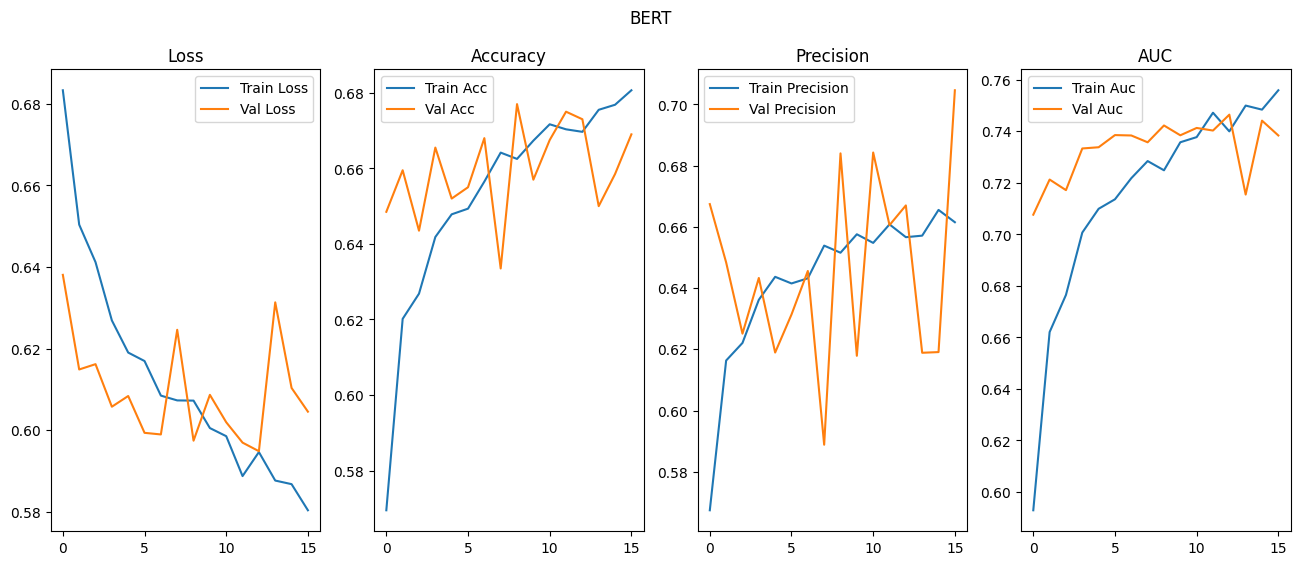

In [ ]:
fig = plt.figure(figsize=(16, 6))

fig.add_subplot(1, 4, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

fig.add_subplot(1, 4, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

fig.add_subplot(1, 4, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Val Precision')
plt.title('Precision')
plt.legend()

fig.add_subplot(1, 4, 4)
plt.plot(history.history['auc'], label='Train Auc')
plt.plot(history.history['val_auc'], label='Val Auc')
plt.title('AUC')
plt.legend()

plt.suptitle("BERT")
plt.show()

In [ ]:
y_preds_prob = bert_model.predict(x_test)
y_preds = np.where(y_preds_prob > 0.5, 1, 0)
print(classification_report(y_test, y_preds))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.67      0.66      0.66      1000
           1       0.66      0.68      0.67      1000

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000



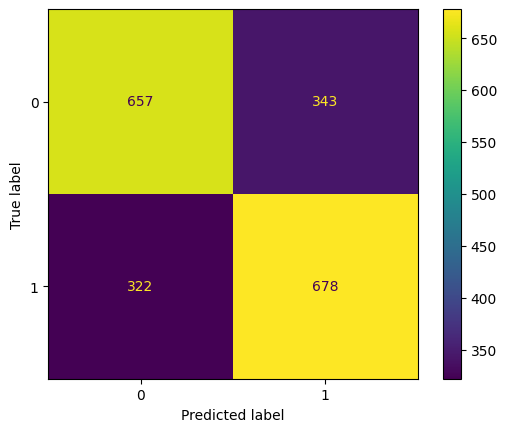

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_pred=y_preds, y_true=y_test)
plt.show()

Les résultats obtenus avec le modèle BERT sont prometteurs. On observe une progression régulière de la performance en apprentissage, avec une précision, une AUC et une loss en validation qui restent globalement stables malgré quelques fluctuations. Ce comportement témoigne d'une bonne généralisation et d'une capacité du modèle à capter efficacement les nuances sémantiques des tweets.

Compte tenu de la nature du problème — analyse de sentiments sur des textes courts et bruités — BERT apparaît comme une solution bien adaptée. Sa capacité à intégrer le contexte lexical rend ce modèle particulièrement pertinent pour les tweets, où le sens peut varier fortement selon l'ordre ou les associations de mots.

Investir davantage de temps et de ressources dans le fine-tuning de ce modèle (avec ajustement de seuil, validation croisée, optimisation des hyperparamètres ou intégration dans un pipeline de production) serait hautement justifié pour améliorer la robustesse du système global.

In [ ]:
bert_model.save(os.path.join(path, "bert_model.keras"))

In [ ]:
end_time = time.time()
print(f"Execution time={end_time-init_time} seconds")

Execution time=2512.2961897850037 seconds


#FIN